Mount Google Drive and Install Libraries

In [ ]:
# Check GPU availability
import torch, platform, os
assert torch.cuda.is_available(), "GPU not detected—check runtime type."
print("GPU:", torch.cuda.get_device_name(0))

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries (TorchIO, tqdm for progress bars)
!pip install torchio tqdm scikit-learn

GPU: NVIDIA A100-SXM4-40GB
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Extract Data Archive


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torch
import torch.nn.functional as F
import nibabel as nib
import torchio as tio
import pandas as pd
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm.notebook import tqdm # Use tqdm.notebook for Colab progress bars
import torch.nn as nn
import torch.optim as optim
from torchvision.models import video # Import video models for 3D ResNets

In [ ]:
# Extract the BIDS archive into /content/adni_bids_raw
# Check if the directory already exists and if it's populated to avoid re-extracting
if not os.path.exists('/content/adni_bids_raw/ADNI_BIDS_raw') or \
   not os.listdir('/content/adni_bids_raw/ADNI_BIDS_raw'):
    print("Extracting data... This may take a while.")
    !mkdir -p /content/adni_bids_raw
    !tar -xf /content/drive/MyDrive/ADNI_project/data/adni_bids_raw.tar.gz -C /content/adni_bids_raw
    print("Data extraction complete.")
else:
    print("Data already extracted.")

# Verify a few files exist
!find /content/adni_bids_raw -type f -iname "*T1w.nii.gz" | head -5

#Explanation:** This block extracts your raw BIDS data from Google Drive to the Colab environment.
#The `if` condition prevents re-extraction if you rerun the notebook and the data is already there, saving time.

Data already extracted.
/content/adni_bids_raw/ADNI_BIDS_raw/sub-126S0405/ses-M00/anat/sub-126S0405_ses-M00_T1w.nii.gz
/content/adni_bids_raw/ADNI_BIDS_raw/sub-005S0448/ses-M00/anat/sub-005S0448_ses-M00_T1w.nii.gz
/content/adni_bids_raw/ADNI_BIDS_raw/sub-012S1292/ses-M00/anat/sub-012S1292_ses-M00_T1w.nii.gz
/content/adni_bids_raw/ADNI_BIDS_raw/sub-067S1253/ses-M00/anat/sub-067S1253_ses-M00_T1w.nii.gz
/content/adni_bids_raw/ADNI_BIDS_raw/sub-023S0916/ses-M00/anat/sub-023S0916_ses-M00_T1w.nii.gz


Re-generate file_labels_final.csv and Split Data

In [ ]:
# 1. Locate all T1w NIfTI files (case-insensitive) and save to a list
# Use find directly as a shell command within Python
t1w_filepaths = !find /content/adni_bids_raw -type f -iname "*T1w.nii.gz"
with open('/content/t1w_list.txt', 'w') as f:
    for path in t1w_filepaths:
        f.write(path + '\n')

# 2. Rebuild df_files with subject_id and session_id
files = [p.strip() for p in open('/content/t1w_list.txt')]
records = []
for p in files:
    parts = p.split(os.sep)
    subj = next((x for x in parts if x.startswith('sub-')), None)
    ses  = next((x for x in parts if x.lower().startswith('ses-')), None) # Case-insensitive for session_id
    records.append({
        'filepath': p,
        'subject_id': subj,
        'session_id': ses
    })
df_files = pd.DataFrame(records)

# 3. Filter to the baseline session ('ses-M00' case-insensitive)
df_files_baseline = df_files[df_files['session_id'].str.lower() == 'ses-m00'].copy()
print(f"Baseline T1w scans (ses-M00): {len(df_files_baseline)}")

# 4. Load ADNIMERGE and prepare clinical labels
adnimerge = pd.read_csv(
    '/content/drive/MyDrive/ADNI_NewDS/ADNIMERGE_08Jun2025.csv',
    low_memory=False
)
df_base = adnimerge[adnimerge['VISCODE'] == 'bl'].copy()

# Normalize subject_id by stripping underscores and prepending 'sub-'
df_base['subject_id'] = 'sub-' + df_base['PTID'].astype(str).str.replace('_', '')

# Correct binary mapping for AD, MCI, CN, SMC
mapping = {
    'CN': 0,
    'SMC': 0, # Assuming SMC (Subjective Memory Complaint) is considered Control
    'EMCI': 1,
    'LMCI': 1,
    'MCI': 1,
    'AD': 1
}
df_base['binary'] = df_base['DX_bl'].map(mapping)

# Drop any rows where binary label couldn't be mapped (e.g., NaNs in DX_bl)
df_base = df_base.dropna(subset=['binary']).copy()
df_base['binary'] = df_base['binary'].astype(int)

print(f"\nBaseline subjects after clinical mapping: {df_base['subject_id'].nunique()}")
print("Clinical baseline class distribution:\n", df_base['binary'].value_counts())

# 5. Merge with df_files_baseline
df_merged = pd.merge(
    df_files_baseline,
    df_base[['subject_id', 'binary']],
    on='subject_id',
    how='inner'
)
df_merged = df_merged.dropna(subset=['binary']).copy()
df_merged['binary'] = df_merged['binary'].astype(int)

print(f"\nFinal merged rows: {len(df_merged)}")
print("Final merged class counts:\n", df_merged['binary'].value_counts())

# Save the final merged CSV
df_merged.to_csv('/content/file_labels_final.csv', index=False)
print("\nSaved → /content/file_labels_final.csv")

# 6. Stratified Train/Val/Test Split
df = pd.read_csv('/content/file_labels_final.csv')
X = df # features (filepaths, subject_ids etc.)
y = df['binary'] # labels for stratification

# Define proportions: 70% train, 15% val, 15% test
# First split: train_val (85%) vs test (15%)
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_val_idx, test_idx in sss_test.split(X, y):
    df_train_val = df.iloc[train_val_idx].copy().reset_index(drop=True)
    df_test = df.iloc[test_idx].copy().reset_index(drop=True)

# Second split: train (approx 70% of total) vs val (approx 15% of total) from train_val
# Calculate test_size for the second split: val_size / (train_size + val_size)
val_size_of_total = 0.15
train_val_size_of_total = 0.85
test_size_for_val_split = val_size_of_total / train_val_size_of_total # This gives approx 0.176

sss_val = StratifiedShuffleSplit(n_splits=1, test_size=test_size_for_val_split, random_state=42)
for train_idx, val_idx in sss_val.split(df_train_val, df_train_val['binary']):
    df_train = df_train_val.iloc[train_idx].copy().reset_index(drop=True)
    df_val = df_train_val.iloc[val_idx].copy().reset_index(drop=True)

# Save to CSVs
df_train.to_csv('/content/train.csv', index=False)
df_val.to_csv('/content/val.csv', index=False)
df_test.to_csv('/content/test.csv', index=False)

print("\n--- Dataset Splits ---")
print(f"TRAIN ({len(df_train)} samples):")
print(df_train['binary'].value_counts(), '\n')

print(f"VAL ({len(df_val)} samples):")
print(df_val['binary'].value_counts(), '\n')

print(f"TEST ({len(df_test)} samples):")
print(df_test['binary'].value_counts(), '\n')

Baseline T1w scans (ses-M00): 187

Baseline subjects after clinical mapping: 2419
Clinical baseline class distribution:
 binary
1    1524
0     895
Name: count, dtype: int64

Final merged rows: 187
Final merged class counts:
 binary
1    127
0     60
Name: count, dtype: int64

Saved → /content/file_labels_final.csv

--- Dataset Splits ---
TRAIN (130 samples):
binary
1    88
0    42
Name: count, dtype: int64 

VAL (28 samples):
binary
1    19
0     9
Name: count, dtype: int64 

TEST (29 samples):
binary
1    20
0     9
Name: count, dtype: int64 



Define Dataset and DataLoader (with TorchIO and WeightedRandomSampler)

In [ ]:
# Define patch_size (same as before)
patch_size = (96, 128, 96)

class VolumeDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vol_np = nib.load(row.filepath).get_fdata().astype('float32')

        # Normalize volume to [0, 1]
        vol_np = (vol_np - vol_np.min()) / (np.ptp(vol_np) + 1e-6)

        # Add channel dimension (C, D, H, W) for TorchIO
        vol_tensor = torch.from_numpy(vol_np).unsqueeze(0)

        # Create a TorchIO Subject
        subject = tio.Subject(t1=tio.ScalarImage(tensor=vol_tensor))

        if self.transform:
            subject = self.transform(subject)

        # Extract transformed volume and ensure float32
        volume = subject.t1.data.float()
        label = torch.tensor(row.binary, dtype=torch.long)
        return volume, label

# Define your TorchIO transforms
train_transform = tio.Compose([
    tio.Resample((1,1,1)), # Resample to 1mm isotropic
    tio.Resize(patch_size), # Resize to a consistent patch size
    tio.RandomFlip(axes=('LR',)), # Randomly flip left-right
    tio.RandomElasticDeformation(), # Elastic deformation (adjust strength if too aggressive)
    tio.RandomBiasField(), # Random bias field
    tio.RandomMotion(), # Random motion artifacts
    tio.RandomGamma(), # Random gamma adjustment for contrast
    tio.RandomNoise(), # Add random Gaussian noise
    # Add more if needed: RandomSpike, RandomGhosting
])

val_transform = tio.Compose([
    tio.Resample((1,1,1)),
    tio.Resize(patch_size),
])

# Function to create DataLoaders, including WeightedRandomSampler for train
def make_loader(csv_file, transform, batch_size=2):
    df_subset = pd.read_csv(csv_file)
    dataset = VolumeDataset(csv_file, transform=transform)

    if 'train' in csv_file: # Apply WeightedRandomSampler only for the training set
        counts = df_subset['binary'].value_counts().sort_index().values
        class_weights = 1.0 / counts
        sample_weights = df_subset['binary'].map(lambda x: class_weights[x]).values
        sampler = WeightedRandomSampler(
            torch.from_numpy(sample_weights).double(), # Weights should be double
            len(sample_weights),
            replacement=True # Use replacement=True for sampling
        )
        # Shuffle should be False when using a sampler
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=2, drop_last=True)
    else:
        # For validation and test, no sampler, just shuffle=False (for consistent evaluation)
        return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)

# Create DataLoaders
train_loader = make_loader('/content/train.csv', train_transform, batch_size=2)
val_loader   = make_loader('/content/val.csv',   val_transform,   batch_size=2)
test_loader  = make_loader('/content/test.csv',  val_transform,   batch_size=2)

# Verify data shape (optional, but good for debugging)
for x, y in train_loader:
    print(f"Train batch shape: {x.shape}, Label shape: {y.shape}")
    break
#Explanation:**
#    * The `VolumeDataset` class handles loading NIfTI files, normalization, and applying TorchIO transforms.
#    * `train_transform` includes more aggressive augmentations.
#    * `val_transform` remains simple for consistent evaluation.
#    * `make_loader` function sets up `DataLoader` instances. It computes class weights and uses `WeightedRandomSampler` for the training loader to address class imbalance. `drop_last=True` for train_loader ensures all batches are of full size.




Train batch shape: torch.Size([2, 1, 96, 128, 96]), Label shape: torch.Size([2])


 Implement the Improved 3D CNN (ResNet18 Backbone)

In [ ]:
import torch.nn as nn
import torch.optim as optim
# Import models directly from torchvision
import torchvision.models as models
# For pre-trained 3D models like R3D_18, they are often in video submodules or specific to certain versions.
# Let's try importing directly from torchvision.models or explicitly from the video module if available.
# The most common pre-trained 3D ResNet is often referred to as R3D_18 (ResNet-18 trained on Kinetics-400 dataset)

class ResNet18_3D(nn.Module):
    def __init__(self, num_classes=2, freeze_backbone=False):
        super().__init__()
        # Load pre-trained R3D_18 from torchvision.models.video
        # Use the latest available weights
        # As of recent torchvision versions, these are directly available under models.video
        # The specific model is `r3d_18` for ResNet-18 3D.

        # Correct way to access r3d_18 with pre-trained weights:
        self.backbone = models.video.r3d_18(weights=models.video.R3D_18_Weights.DEFAULT) # Note: it's `r3d_18`, not `resnet18`

        # Adjust the first convolutional layer for single-channel input (MRI)
        # Original: self.backbone.stem.0 = nn.Conv3d(3, 64, ...) for `r3d_18`
        # Access the first conv layer through `backbone.stem` for `r3d_18`
        original_conv1 = self.backbone.stem[0]
        self.backbone.stem[0] = nn.Conv3d(
            1, # Change input channels from 3 to 1
            original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=original_conv1.bias
        )

        # Freeze backbone layers if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            # Unfreeze the final classification layer for fine-tuning
            self.backbone.fc.requires_grad = True

        # Replace the final classification layer to match num_classes
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

# --- Training Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Compute class weights once based on the training dataset
# (Ensure train_df is loaded from /content/train.csv from previous step)
# This part assumes train_df is already defined from the previous successful execution of step 5
# If not, add: train_df = pd.read_csv('/content/train.csv')
train_df = pd.read_csv('/content/train.csv') # Ensure this line is present if not already.
counts = train_df['binary'].value_counts().sort_index().values
class_weights = torch.tensor([1.0/counts[0], 1.0/counts[1]],
                             dtype=torch.float32,
                             device=device)
print(f"Class weights: {class_weights}")

# Set up loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Use a dummy model for optimizer/scheduler definition here;
# actual model will be initialized per fold in the CV loop
dummy_model = ResNet18_3D().to(device)
optimizer = optim.AdamW(dummy_model.parameters(), lr=1e-5, weight_decay=1e-5) # Lower LR
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15) # T_max is max_epochs

# --- Training and Evaluation Functions ---
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader, desc="Train"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_loader(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Eval"):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return total_loss / len(loader), correct / total

Class weights: tensor([0.0238, 0.0114], device='cuda:0')


Run 5-Fold Cross-Validation Ensemble Training and Evaluation

Starting 5-Fold Cross-Validation...

--- Fold 1/5 ---


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/20: Train Loss=0.7551, Val Loss=1.1461, Val Acc=34.375%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/20: Train Loss=0.7050, Val Loss=1.1419, Val Acc=34.375%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/20: Train Loss=0.7017, Val Loss=1.3016, Val Acc=34.375%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/20: Train Loss=0.6767, Val Loss=1.5091, Val Acc=34.375%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/20: Train Loss=0.6912, Val Loss=1.4864, Val Acc=34.375%
Early stopping triggered at epoch 5. No improvement for 3 epochs.


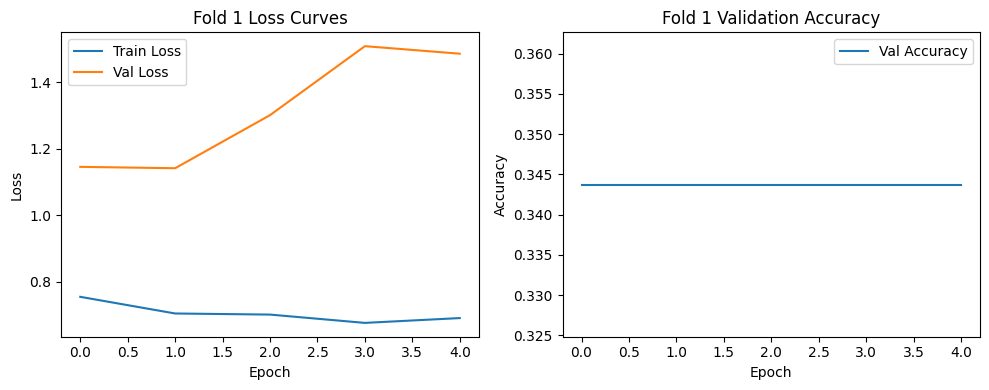

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

→ Fold 1 best val acc for best checkpoint: 34.375%

--- Fold 2/5 ---


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/20: Train Loss=0.7110, Val Loss=0.6711, Val Acc=56.250%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/20: Train Loss=0.6800, Val Loss=0.6972, Val Acc=56.250%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/20: Train Loss=0.6865, Val Loss=0.6629, Val Acc=68.750%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/20: Train Loss=0.7158, Val Loss=0.6576, Val Acc=68.750%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/20: Train Loss=0.6846, Val Loss=0.7123, Val Acc=43.750%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/20: Train Loss=0.6536, Val Loss=0.6807, Val Acc=59.375%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/20: Train Loss=0.6769, Val Loss=0.7379, Val Acc=34.375%
Early stopping triggered at epoch 7. No improvement for 3 epochs.


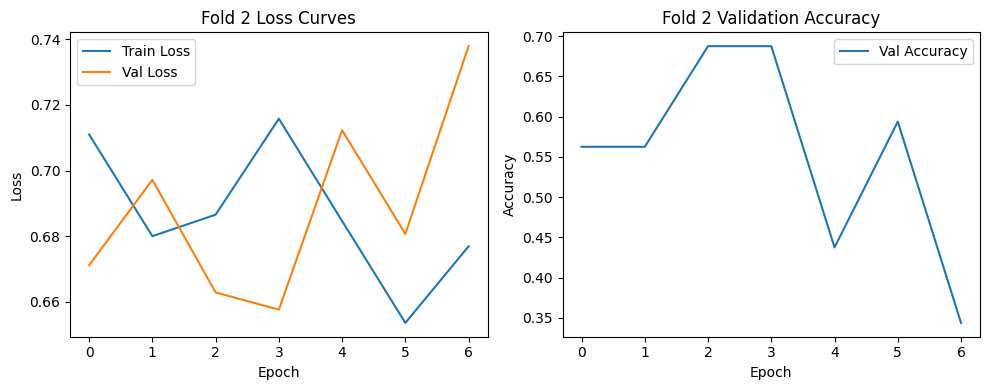

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

→ Fold 2 best val acc for best checkpoint: 68.750%

--- Fold 3/5 ---


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/20: Train Loss=0.7112, Val Loss=0.6593, Val Acc=68.750%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/20: Train Loss=0.7042, Val Loss=0.7213, Val Acc=37.500%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/20: Train Loss=0.6796, Val Loss=0.7286, Val Acc=31.250%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/20: Train Loss=0.6755, Val Loss=0.7070, Val Acc=28.125%
Early stopping triggered at epoch 4. No improvement for 3 epochs.


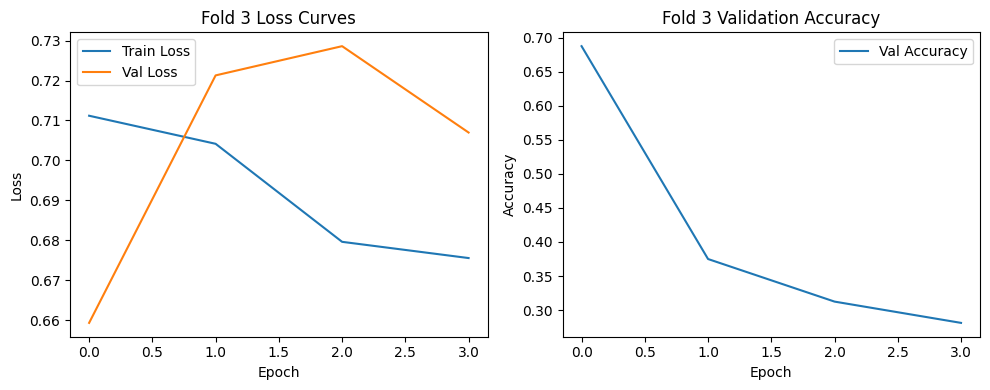

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

→ Fold 3 best val acc for best checkpoint: 68.750%

--- Fold 4/5 ---


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/20: Train Loss=0.6805, Val Loss=0.7616, Val Acc=29.032%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/20: Train Loss=0.6927, Val Loss=0.7438, Val Acc=35.484%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/20: Train Loss=0.6979, Val Loss=0.7565, Val Acc=35.484%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/20: Train Loss=0.6795, Val Loss=0.7039, Val Acc=41.935%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/20: Train Loss=0.6508, Val Loss=0.6735, Val Acc=67.742%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/20: Train Loss=0.7361, Val Loss=0.7648, Val Acc=32.258%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/20: Train Loss=0.6380, Val Loss=0.6689, Val Acc=61.290%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/20: Train Loss=0.6555, Val Loss=0.6876, Val Acc=61.290%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/20: Train Loss=0.6508, Val Loss=0.6675, Val Acc=64.516%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/20: Train Loss=0.6536, Val Loss=0.6675, Val Acc=67.742%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/20: Train Loss=0.6729, Val Loss=0.7623, Val Acc=35.484%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/20: Train Loss=0.6599, Val Loss=0.6831, Val Acc=41.935%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/20: Train Loss=0.6439, Val Loss=0.7681, Val Acc=35.484%
Early stopping triggered at epoch 13. No improvement for 3 epochs.


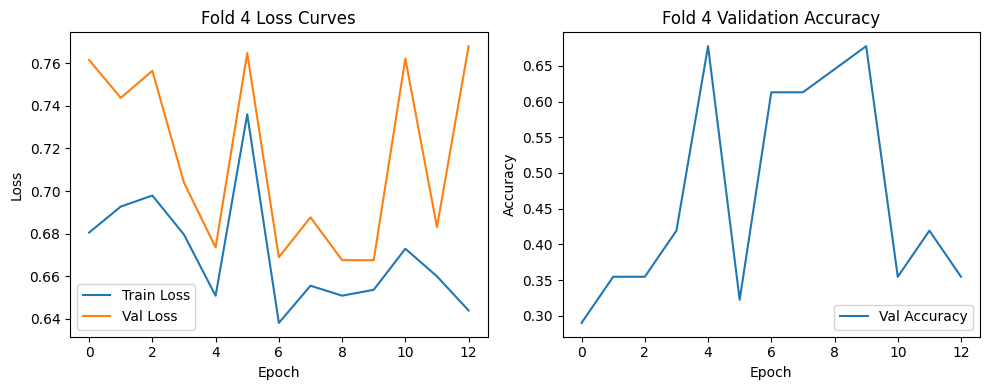

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

→ Fold 4 best val acc for best checkpoint: 67.742%

--- Fold 5/5 ---


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/20: Train Loss=0.7990, Val Loss=0.7835, Val Acc=38.710%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/20: Train Loss=0.7428, Val Loss=0.7384, Val Acc=45.161%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/20: Train Loss=0.7235, Val Loss=0.7231, Val Acc=48.387%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/20: Train Loss=0.6918, Val Loss=0.6999, Val Acc=48.387%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/20: Train Loss=0.7083, Val Loss=0.8187, Val Acc=32.258%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/20: Train Loss=0.7049, Val Loss=0.9350, Val Acc=32.258%


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/20: Train Loss=0.6772, Val Loss=1.0936, Val Acc=32.258%
Early stopping triggered at epoch 7. No improvement for 3 epochs.


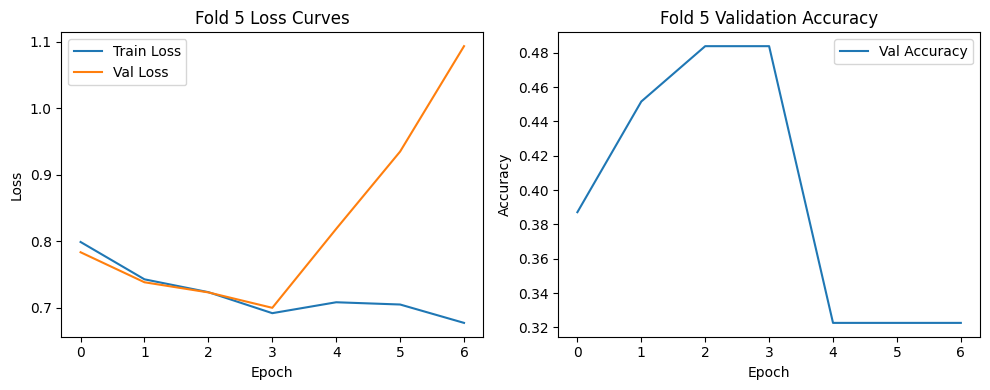

Eval:   0%|          | 0/16 [00:00<?, ?it/s]

→ Fold 5 best val acc for best checkpoint: 48.387%

--- Cross-Validation Training Complete ---
Average best validation accuracy across folds: 57.601%

--- Evaluating Ensemble on Test Set ---


Test Ensemble:   0%|          | 0/15 [00:00<?, ?it/s]


--- Ensemble Test Set Results (0.5 Threshold) ---
Test Accuracy: 0.690
Precision: 0.762
Recall: 0.800
F1-Score: 0.780
AUC: 0.578
Confusion Matrix:
 [[ 4  5]
 [ 4 16]]


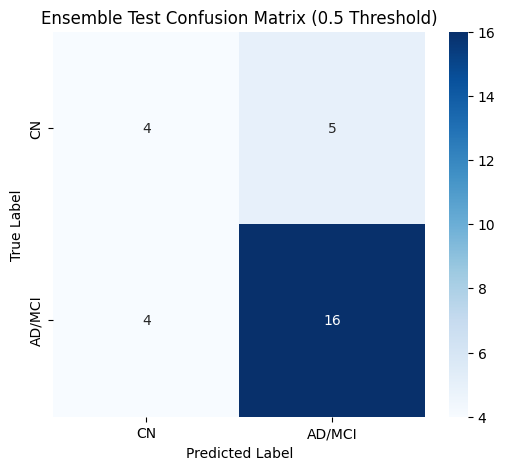

NameError: name 'roc_curve' is not defined

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, f1_score
import copy
import matplotlib.pyplot as plt
import seaborn as sns # for heatmap convenience

# Combine train+val for CV
df_tv = pd.concat([pd.read_csv('/content/train.csv'),
                   pd.read_csv('/content/val.csv')]).reset_index(drop=True)
X_cv, y_cv = df_tv, df_tv['binary'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_states = []
all_fold_metrics = [] # To store metrics for each fold

# Training loop parameters
num_epochs_per_fold = 20 # Increased epochs for better convergence
early_stopping_patience = 3 # Stop if val loss doesn't improve for this many epochs

print("Starting 5-Fold Cross-Validation...")
for fold, (train_idx, val_idx) in enumerate(skf.split(X_cv, y_cv), 1):
    print(f"\n--- Fold {fold}/5 ---")
    # Subset CSVs for current fold
    X_cv.iloc[train_idx].to_csv('/content/tmp_train.csv', index=False)
    X_cv.iloc[val_idx].to_csv('/content/tmp_val.csv', index=False)

    # Rebuild loaders for the current fold
    # Ensure batch_size is 2 or more, and num_workers
    current_train_loader = make_loader('/content/tmp_train.csv', train_transform, batch_size=2)
    current_val_loader = make_loader('/content/tmp_val.csv', val_transform, batch_size=2)

    # Fresh model and optimizer for each fold
    model = ResNet18_3D(num_classes=2, freeze_backbone=False).to(device) # Can try freeze_backbone=True for initial epochs
    # Re-initialize optimizer and scheduler for each fold
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5) # Keep lower LR
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs_per_fold) # T_max should be num_epochs_per_fold

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_fold_state = None
    fold_train_losses = []
    fold_val_losses = []
    fold_val_accs = []

    for epoch in range(1, num_epochs_per_fold + 1):
        train_loss = train_epoch(model, current_train_loader, criterion, optimizer, device)
        val_loss, val_acc = eval_loader(model, current_val_loader, criterion, device)
        scheduler.step() # Call scheduler.step() after each epoch

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_val_accs.append(val_acc)

        print(f"Epoch {epoch}/{num_epochs_per_fold}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.3%}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_fold_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch}. No improvement for {early_stopping_patience} epochs.")
                break # Break out of inner epoch loop

    # Plot training/validation curves for the current fold
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(fold_train_losses, label='Train Loss')
    plt.plot(fold_val_losses, label='Val Loss')
    plt.title(f'Fold {fold} Loss Curves')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(fold_val_accs, label='Val Accuracy')
    plt.title(f'Fold {fold} Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

    if best_fold_state:
        fold_states.append(best_fold_state)
        # Evaluate the best model for this fold on its validation set to store metrics
        model.load_state_dict(best_fold_state)
        _, best_fold_val_acc = eval_loader(model, current_val_loader, criterion, device)
        print(f"→ Fold {fold} best val acc for best checkpoint: {best_fold_val_acc:.3%}")
        all_fold_metrics.append(best_fold_val_acc)
    else:
        print(f"Warning: No best model state saved for Fold {fold}.")

print("\n--- Cross-Validation Training Complete ---")
print(f"Average best validation accuracy across folds: {np.mean(all_fold_metrics):.3%}")

# Ensemble on test set
all_probs, all_labels = [], []
model_for_inference = ResNet18_3D(num_classes=2).to(device) # A fresh model instance for inference

print("\n--- Evaluating Ensemble on Test Set ---")
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Test Ensemble"):
        x = x.to(device)
        batch_probs = []
        for fold_idx, state_dict in enumerate(fold_states):
            model_for_inference.load_state_dict(state_dict)
            model_for_inference.eval() # Set to eval mode
            outputs = model_for_inference(x)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            batch_probs.append(probs)
        all_probs.extend(np.mean(batch_probs, axis=0)) # Average probabilities across folds
        all_labels.extend(y.numpy())

# Final metrics with default 0.5 threshold
preds = [1 if p >= 0.5 else 0 for p in all_probs]

test_acc = accuracy_score(all_labels, preds)

# --- CRITICAL CHANGE HERE: Explicitly set pos_label=1 ---
test_prec, test_recall, test_f1, _ = precision_recall_fscore_support(
    all_labels, preds, average='binary', zero_division=0, pos_label=1
)
test_auc = roc_auc_score(all_labels, all_probs)
test_cm = confusion_matrix(all_labels, preds)

print(f"\n--- Ensemble Test Set Results (0.5 Threshold) ---")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Precision: {test_prec:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1-Score: {test_f1:.3f}")
print(f"AUC: {test_auc:.3f}")
print("Confusion Matrix:\n", test_cm) # <--- Added this back for numerical output

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["CN", "AD/MCI"],
            yticklabels=["CN", "AD/MCI"])
plt.xlabel("Predicted Label"); plt.ylabel("True Label")
plt.title("Ensemble Test Confusion Matrix (0.5 Threshold)")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Test ROC Curve')
plt.legend(); plt.grid(); plt.show()

# Threshold sweep to maximize F1 (from your previous note)
thresholds = np.linspace(0, 1, 101)
best_f1_th, best_f1_score, best_f1_acc = 0, -1, 0.5

for t in thresholds:
    preds_t = [1 if p >= t else 0 for p in all_probs]
    f1 = f1_score(all_labels, preds_t, zero_division=0, pos_label=1) # <--- Added pos_label=1 here too
    acc = accuracy_score(all_labels, preds_t)
    if f1 > best_f1_score:
        best_f1_score, best_f1_th, best_f1_acc = f1, t, acc

print(f"\n--- Ensemble Test Set Results (Optimal F1 Threshold) ---")
print(f"Optimal F1 Threshold: {best_f1_th:.2f}")
print(f"Optimal F1-Score: {best_f1_score:.3f}")
print(f"Accuracy at Optimal F1 Threshold: {best_f1_acc:.3f}")


#* **Explanation:**
#    * This is the core training and evaluation loop.
#   * It implements the 5-fold cross-validation. For each fold:
#        * It creates temporary `tmp_train.csv` and `tmp_val.csv` files.
#        * Initializes a fresh `ResNet18_3D` model.
#        * Sets up a new `AdamW` optimizer and `CosineAnnealingLR` scheduler.
#        * Trains for `num_epochs_per_fold` with `early_stopping_patience`.
#        * Saves the `state_dict` of the best model (based on validation loss) for that fold.
#        * Plots the loss and accuracy curves for each fold to help you monitor performance.
#    * After all folds are trained, it performs ensemble inference on the held-out `test_loader` by averaging the probabilities from all saved fold models.
#    * Finally, it calculates and prints various performance metrics (Accuracy, Precision, Recall, F1, AUC, Confusion Matrix) for the ensemble on the test set.
#    * It also includes the threshold sweep to find the optimal F1-score, as discussed.

In [ ]:
print("\n--- Raw Predictions and Labels for Debugging ---")
print(f"Length of all_labels: {len(all_labels)}")
print(f"all_labels (first 10): {all_labels[:10]}")
print(f"Length of preds: {len(preds)}")
print(f"preds (first 10): {preds[:10]}")
print(f"Value counts of all_labels: {pd.Series(all_labels).value_counts()}")
print(f"Value counts of preds: {pd.Series(preds).value_counts()}")


--- Raw Predictions and Labels for Debugging ---
Length of all_labels: 29
all_labels (first 10): [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Length of preds: 29
preds (first 10): [1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Value counts of all_labels: 1    20
0     9
Name: count, dtype: int64
Value counts of preds: 1    27
0     2
Name: count, dtype: int64
